In [1]:
!pip install pytorch-ignite

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
# 以下、PyTorch-Igniteからのインポート
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers


In [3]:
DATA_DIR='./data' # データ保存用のディレクトリ
IMAGE_SIZE = 32 # 入力画像1辺のサイズ
NUM_CLASSES = 10 # 分類先のクラス数
NUM_WORKERS = 12 # データローダーが使用するサブプロセスの数を指定
BATCH_SIZE = 32 # ミニバッチのサイズ
LEARNING_RATE = 1e-3 # 学習率
WEIGHT_DECAY = 1e-1 # オプティマイザーの重み減衰率
EPOCHS = 100 # 学習回数


In [4]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)


device: cuda


In [5]:
# トレーニングデータに適用する一連の変換操作をtransforms.Composeにまとめる
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # ランダムに左右反転
    # 4ピクセルのパディングを挿入してランダムに切り抜く
    transforms.RandomCrop(IMAGE_SIZE, padding=4),
    # 画像のコントラスト、彩度、色相をランダムに変化させる
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor() # テンソルに変換
])


In [6]:
# CIFAR-10データセットのトレーニングデータを読み込み、データ拡張を適用
train_dset = datasets.CIFAR10(
    root=DATA_DIR, train=True, download=True, transform=train_transform)
# CIFAR-10データセットのテストデータを読み込んでテンソルに変換する処理のみを行う
test_dset = datasets.CIFAR10(
    root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())


100%|██████████| 170498071/170498071 [00:12<00:00, 13502016.88it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
# トレーニング用のデータローダーを作成
train_loader = torch.utils.data.DataLoader(
    train_dset,
    batch_size=BATCH_SIZE,
    shuffle=True, # 抽出時にシャッフルする
    num_workers=NUM_WORKERS, # データ抽出時のサブプロセスの数を指定
    pin_memory=True # データを固定メモリにロード
    )

# テスト用のデータローダーを作成
test_loader = torch.utils.data.DataLoader(
    test_dset,
    batch_size=BATCH_SIZE,
    shuffle=False, # 抽出時にシャッフルしない
    num_workers=NUM_WORKERS, # データ抽出時のサブプロセスの数を指定
    pin_memory=True # データを固定メモリにロード
    )


In [8]:
def init_linear(m):
    """ レイヤーの重みとバイアスを初期化する

    Args:
        m (nn.Module): 畳み込み層または全結合層のPyTorchモジュール
    """
    # モジュールが畳み込み層（nn.Conv2d）または全結合層（nn.Linear）であるかチェックする
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        # 重みをKaiming正規分布で初期化する
        nn.init.kaiming_normal_(m.weight)
        # バイアスが存在する場合、バイアスをゼロで初期化する
        if m.bias is not None:
            nn.init.zeros_(m.bias)


In [9]:
class Partial:
    """ 引数をバインドしてモジュールを実行するためのユーティリティクラス

    Attributes:
        module (Callable): 部分的に引数をバインドする対象のモジュール（関数やクラス）
        args (tuple): 事前にバインドする位置引数
        kwargs (dict): 事前にバインドするキーワード引数
    """
    def __init__(self, module, *args, **kwargs):
        """ コンストラクター

        Args:
            module (Callable): 部分的に引数をバインドする対象のモジュール(クラスなど)
            *args: 事前にバインドする位置引数のリスト。
            **kwargs: 事前にバインドするキーワード引数の辞書。
        """
        self.module = module  # モジュールを設定
        self.args = args  # 事前にバインドする位置引数を設定
        self.kwargs = kwargs  # 事前にバインドするキーワード引数を設定

    def __call__(self, *args_c, **kwargs_c):
        """ Partialのインスタンスが実行された際に
            事前の引数と追加の引数を組み合わせてモジュールを実行する

        Args:
            *args_c: 呼び出し時に渡される追加の位置引数
            **kwargs_c: 呼び出し時に渡される追加のキーワード引数

        Returns:
            モジュールの実行結果
        """
        # 事前に設定された引数と追加の引数を組み合わせてモジュールを実行
        return self.module(
            *args_c,  # 呼び出し時の位置引数を展開
            *self.args,  # 事前の位置引数を展開
            **kwargs_c,  # 呼び出し時のキーワード引数を展開
            **self.kwargs  # 事前のキーワード引数を展開
        )


In [10]:
class LayerNormChannels(nn.Module):
    """ チャンネル次元に正規化を適用するネットワーク

    Attributes:
        norm (nn.LayerNorm): 正規化レイヤー
    """
    def __init__(self, channels):
        """ チャンネル数を指定してLayerNormを初期化する

        Args:
            channels (int): 正規化を適用するチャンネル次元数
                            128, 256, 512,
        """
        super().__init__()
        # 入力次元数をチャンネル次元数にしてLayerNormを初期化
        self.norm = nn.LayerNorm(channels)

    def forward(self, x):
        """ フォワードパス
            入力テンソルに対して正規化レイヤーを適用する

        Args:
            x: (bs, チャンネル次元, 特徴マップ高さ, 特徴マップ幅)
               (bs, 128, 16, 16)
               (bs, 256, 8, 8)
               (bs, 512, 4, 4)

        Returns:
            LayerNormを適用したテンソル
               (bs, 128, 16, 16)
               (bs, 256, 8, 8)
               (bs, 512, 4, 4)
        """
        x = x.transpose(1, -1)  # チャンネル次元を最後の次元に移動
        x = self.norm(x)  # 正規化レイヤーを適用
        x = x.transpose(-1, 1)  # チャンネル次元を元の位置に戻す

        return x


In [11]:
class ConvBlock(nn.Sequential):
    """ 畳み込み層、バッチ正規化層、GELU関数で構成されるネットワーク
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, groups=1):
        """ ネットワークを初期化する

        Args:
            in_channels (int): チャンネル次元数。3, 64, 256, 128,
            out_channels (int): 出力チャンネル次元数　64　256　512.
            kernel_size (int, optional): 畳み込みカーネルのサイズ。 3, 1,
            stride (int, optional): 畳み込みのストライド。1, 2,
            groups (int, optional): グループ数。1, 256,

        Returns:
            None
        """
        # パディングのサイズを計算
        padding = (kernel_size - 1) // 2
        # nn.Sequentialのコンストラクターを呼び出し、各レイヤーを配置
        super().__init__(
            nn.Conv2d(
                in_channels, # 入力チャンネル次元数
                out_channels, # 出力チャンネル次元数
                kernel_size, # カーネルサイズ
                stride=stride, # ストライド
                padding=padding, # パディング
                groups=groups, # グループ数
                bias=False # バイアス項は使用しない
            ),
            nn.BatchNorm2d(out_channels), # 出力チャンネルにバッチ正規化を適用
            nn.GELU() # GELU活性化関数
        )


In [12]:
def get_shortcut(in_channels, out_channels, stride):
    """ 残差接続におけるショートカット経路を作成する

    Args:
        in_channels (int): 入力チャンネル次元数。64, 128, 256, 512
        out_channels (int): 出力チャンネル次元数。64, 128, 256, 512
        stride (int): ストライド。1, 2,

    Returns:
        nn.Module: ショートカット経路(モジュール)
    """

    # 入力チャンネル次元数と出力チャンネル次元数が同じで、ストライドが1の場合は
    # Identityレイヤーをショートカットとして設定
    if (in_channels == out_channels and stride == 1):
        shortcut = nn.Identity()  # 入力をそのまま出力するIdentityレイヤー
    else:
        # それ以外の場合は、カーネルサイズ1x1の畳み込み層をショートカットとして設定
        # 残差接続を行うレイヤーからの出力テンソルのチャンネル数に合わせる
        shortcut = nn.Conv2d(in_channels, out_channels, 1)

    # ストライドが1より大きい場合は、ダウンサンプリングのためのMaxPool2dレイヤーを配置し、
    # その後にショートカット(Conv2dまたはIdentity)を配置する
    if stride > 1:
        shortcut = nn.Sequential(
            nn.MaxPool2d(stride), # 最大値プーリングを配置
            shortcut # ショートカットを配置
        )

    return shortcut


In [13]:
class Residual(nn.Module):
    """ 残差接続を行うネットワーク

    Attributes:
        shortcut: ショートカット経路
        residual: 受け取ったレイヤーを連結したメインの経路
        gamma: メインパスの出力をスケーリングするための学習可能なパラメーター
    """
    def __init__(self, *layers, shortcut=None):
        """ コンストラクター
        Args:
            *layers: レイヤーのシーケンス
            shortcut: ショートカット経路
        """
        super().__init__()
        # shortcutがNoneの場合、ショートカット経路にnn.Identityを設定
        # nn.Identityは入力をそのまま出力するモジュール
        self.shortcut = nn.Identity() if shortcut is None else shortcut
        # 受け取ったレイヤーをnn.Sequentialで連結する
        self.residual = nn.Sequential(*layers)
        # 学習可能な初期値ゼロのパラメータを1個作成
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        """
        Args:
            x: 入力テンソル (bs, 64, 32, 32)
                            (bs, 128, 16, 16)
                            (bs, 256, 8, 8)
                            (bs, 512, 4, 4)
        Returns:
            ショートカット経路の出力とスケーリングしたメインパスの出力を足し合わせた結果
        """
        return self.shortcut(x) + self.gamma * self.residual(x)


In [14]:
class SqueezeExciteBlock(nn.Module):
    """ Squeeze-and-Excitationブロック

    Attributes:
        out_channels (int): 出力チャンネル数。
        se (nn.Sequential): SEブロックを構成するシーケンシャルモジュール。
    """
    def __init__(self, channels, reduction=4):
        """ SEブロックを初期化する

        Args:
            channels (int): 入力チャンネルの次元数。256, 512,
            reduction (int): チャネル次元数の縮小率。デフォルトは4
        """
        super().__init__()
        self.out_channels = channels # 出力チャンネル次元数(入力と同じ)
        channels_r = channels // reduction # 縮小後のチャンネル次元数を計算

        # SEブロックを構成するレイヤー、モジュールを配置
        self.se = nn.Sequential(
            # 各チャンネルごとの全空間の平均を計算し、1x1の特徴マップに変換
            nn.AdaptiveAvgPool2d(1),
            # 1x1の畳み込みでチャンネル次元数をchannels_rに縮小
            nn.Conv2d(channels, channels_r, kernel_size=1),
            nn.GELU(),  # GELU活性化関数を適用
            # 1x1の畳み込みでチャネル数を元に戻す
            nn.Conv2d(channels_r, channels, kernel_size=1),
            nn.Sigmoid()  # シグモイド関数を適用して各チャンネルのスケールを計算する
        )

    def forward(self, x):
        """ フォワードパス

        Args:
            x: 形状:(bs, channels, height, width)
               (32, 256, 32, 32)
               (32, 256, 16, 16)
               (32, 512, 16, 16)
        Returns:
            SEブロックを適用した出力テンソル。形状は入力と同じ
        """
        # 入力テンソルとself.se(x)の出力との要素ごとの積を求めることで、
        # ブロードキャストによってテンソルの形状を一致させる
        # ブロードキャスト規則により、どちらかの次元のサイズが1の場合、
        # その次元は対応する次元のサイズに自動的に拡張される
        # 具体的には、self.se(x) の形状 (bs, channels, 1, 1) が、
        # 入力テンソル x の形状 (bs, channels, height, width) にブロードキャストされる
        # これにより、self.se(x) が x と同じ形状に拡張され、
        # 各チャンネルごとにスケーリングが適用される
        return x * self.se(x)


In [15]:
class MBConv(Residual):
    """ Mobile Inverted Residual Bottleneck Convolution (MBConv) ブロック
        Residualのサブクラス
    """
    def __init__(self, in_channels, out_channels, shape,
                 kernel_size=3, stride=1, expansion_factor=4):
        """
        Args:
            in_channels (int): 入力チャンネル数。64,128,
            out_channels (int): 出力チャンネル数。64,128,
            shape (tuple): 入力テンソルの形状。(32,32),(16,16)
            kernel_size (int, optional): 畳み込みカーネルのサイズ。3,
            stride (int, optional): 畳み込みのストライド。1,2,
            expansion_factor (int, optional): チャンネル数を拡張する係数。4,
        """
        # 拡張するチャンネル次元数を計算
        mid_channels = in_channels * expansion_factor
        # Residualクラスのコンストラクターを実行
        super().__init__(
            # 入力チャンネル次元に対するバッチ正規化
            nn.BatchNorm2d(in_channels),
            nn.GELU(),  # GELU活性化関数
            # 第1のConvBlockを配置
            # 1x1のフィルターを使用した畳み込みで、チャンネル次元数を拡張
            ConvBlock(in_channels, mid_channels, 1),
            # 第2のConvBlockを配置
            # groupsに拡張後のチャンネル次元数を設定、チャンネルごとに畳み込みを行う
            ConvBlock(
                mid_channels, mid_channels, kernel_size, stride=stride,
                groups=mid_channels),
            # Squeeze-and-Excitationブロックで各チャンネルの重要度を学習、重み付けを行う
            SqueezeExciteBlock(mid_channels),
            # 1x1のフィルターを使用した畳み込みで、チャンネル次元数を縮小、元に戻す
            nn.Conv2d(mid_channels, out_channels, 1),
            # ショートカット接続を配置
            shortcut = get_shortcut(in_channels, out_channels, stride)
        )


In [16]:
class SelfAttention2d(nn.Module):
    """ 2次元自己注意機構(2D Multi-Head Self-Attention)

    Attributes:
        heads: ヘッドの数
        head_channels: ヘッドのチャンネル数
        scale: Attentionスコアをスケーリングするための係数
        to_keys: キーを計算するための1x1畳み込み層
        to_queries: クエリを計算するための1x1畳み込み層
        to_values: バリューを計算するための1x1畳み込み層
        unifyheads: ヘッドを統合するための1x1畳み込み層
        pos_enc: 相対位置エンコーディングのパラメーター
        register_buffer: 相対位置インデックスを保存するバッファ
        drop: ドロップアウトレイヤー
    """
    def __init__(self, in_channels, out_channels, head_channels, shape, p_drop=0.):
        """
        Args:
            in_channels: 入力チャネル数.　128, 256, 512のいずれか
            out_channels: 出力チャネル数. 256, 512のいずれか
            head_channels: ヘッドのチャネル数. 32
            shape: 特徴マップの高さと幅. (8,8), (4,4)のいずれか
            p_drop: ドロップアウト率. 0.3
        """
        super().__init__()
        # out_channelsをhead_channelsで割ってヘッドの数を計算
        # out_channels=256の場合、self.heads=8
        # out_channels=512の場合、self.heads=16
        self.heads = out_channels // head_channels
        # ヘッドのチャンネル数(32)を設定
        self.head_channels = head_channels
        # スケーリング係数としてhead_channelsの平方根の逆数を計算
        self.scale = head_channels**-0.5

        # 特徴マップからキーを生成する1x1畳み込み層
        self.to_keys = nn.Conv2d(in_channels, out_channels, 1)
        # クエリを生成する1x1畳み込み層
        self.to_queries = nn.Conv2d(in_channels, out_channels, 1)
        # バリューを生成する1x1畳み込み層
        self.to_values = nn.Conv2d(in_channels, out_channels, 1)
        # ヘッドを統合する1x1畳み込み層
        self.unifyheads = nn.Conv2d(out_channels, out_channels, 1)

        # 入力特徴マップの高さと幅を取得
        # self.heads=8の場合:height=8, width=8
        # self.heads=16の場合:height=4, width=4
        height, width = shape
        # 相対位置エンコーディングを学習するための学習可能なパラメーターを作成
        # self.heads=8の場合: height=8, width=8なので、
        #（2 * 8－1)*（2 * 8－1) = 225通りの相対位置 -> テンソル形状:(8, 225)
        # self.heads=16の場合: height=4, width=4なので、
        #（2 * 4－1)*（2 * 4－1) = 49通りの相対位置 -> テンソル形状:(16, 49)
        self.pos_enc = nn.Parameter(
            # 標準正規分布に従うランダムな値を生成
            torch.randn(
                # 第1次元はヘッド数
                self.heads,
                # 第2次元は相対位置の組み合わせ数
                (2 * height - 1) * (2 * width - 1)))

        # 相対位置インデックスを取得し、バッファに登録
        # height,width = 8の場合の形状: (4096,)
        #  height,width = 4の形状: (256,)
        self.register_buffer("relative_indices", self.get_indices(height, width))

        self.drop = nn.Dropout(p_drop)  # ドロップアウトレイヤー

    def forward(self, x):
        """ フォワードパス
        Args:
            x: 入力テンソル
               (bs, 128, 8, 8), (bs, 256, 8, 8), (bs, 256, 4, 4),(bs, 512, 4, 4)
        Returns:
            out: 出力テンソル
        """
        b, _, h, w = x.shape  # バッチサイズと入力の高さ、幅を取得

        # キー、クエリ、バリューの形状:
        #  (bs, ヘッドの数, ヘッドのチャンネル数, 高さ * 幅)
        #  self.heads=8の場合: (bs, 8, 32, 64)
        #  self.heads=16の場合: (bs, 16, 32, 16)
        #
        # キーを計算し、形状を変換
        keys = self.to_keys(x).view(b, self.heads, self.head_channels, -1)
        # バリューを計算し、形状を変換
        values = self.to_values(x).view(b, self.heads, self.head_channels, -1)
        # クエリを計算し、形状を変換
        queries = self.to_queries(x).view(b, self.heads, self.head_channels, -1)

        # キーとクエリの行列積を計算してアテンションスコアを得る
        # attの形状:(bs, ヘッドの数, h * w, h * w)
        # (bs, 8, 64, 32)@(bs, 8, 32, 64)の場合: (bs, 8, 64, 64)
        # (bs, 16, 16, 32))@(bs, 16, 32, 16)の場合: (bs, 16, 16, 16)
        att = keys.transpose(-2, -1) @ queries

        # 相対位置インデックスを拡張して、ヘッドの数だけ用意する
        # h,w = 8の場合の形状(4096,)が(8, 4096)に拡張
        # h,w = 4の場合の形状(256,)が(16, 256)に拡張
        indices = self.relative_indices.expand(self.heads, -1)

        # 相対位置エンコーディングをインデックスに基づいて取得
        # rel_pos_encの形状: h,w = 8の場合: (8, 4096)
        #                    h,w = 4の場合: (16, 256)
        rel_pos_enc = self.pos_enc.gather(-1, indices)

        # rel_pos_encの最後の次元を特徴マップの位置数 (h * w) に基づいて
        # (h * w, h * w) の2次元形状に再構成する
        # rel_pos_encの形状: h,w = 8の場合: (8, 64, 64)
        #                    h,w = 4の場合: (16, 16, 16)
        rel_pos_enc = rel_pos_enc.unflatten(-1, (h * w, h * w))

        # アテンションスコアをスケーリングし、相対位置エンコーディングを加える
        # attの形状: (bs, ヘッドの数, h * w, h * w)
        # h,w = 8の場合: (bs, 8, 64, 64)
        # h,w = 4の場合: (bs, 16, 16, 16)
        att = att * self.scale + rel_pos_enc

        # ソフトマックスを適用して正規化
        att = F.softmax(att, dim=-2)

        # バリューとアテンションスコアの行列積を計算する
        # outの形状:(bs, ヘッドの数, ヘッドのチャンネル数, h * w)
        # (bs, 8, 32, 64)@(bs, 8, 64, 64)の場合: (bs, 8, 32, 64)
        # (bs, 16, 32, 16)@(bs, 16, 16, 16)の場合: (bs, 16, 32, 16)
        out = values @ att

        # 形状を元の形状(bs, heads * head_channels, h, w)に戻す
        # (bs, 8, 32, 64)の場合: (bs, 256, 8, 8)
        # (bs, 16, 32, 16)の場合: (bs, 512, 4, 4)
        out = out.view(b, -1, h, w)

        # outの形状: (bs, 256, 8, 8),または(bs, 512, 4, 4)
        out = self.unifyheads(out)  # ヘッドを統合

        out = self.drop(out)  # ドロップアウトを適用
        return out  # 出力を返す

    @staticmethod
    def get_indices(h, w):
        """  相対位置インデックスを作る
        Args:
            h: 特徴マップの高さ。8, 4のいずれか
            w: 特徴マップの幅。8, 4のいずれか
        Returns:
            indices: 相対位置のインデックス
        """

        # 0からh - 1までの高さ方向のインデックス値を作成
        y = torch.arange(h, dtype=torch.long)
        # 0からw - 1までの幅方向のインデックス値を作成
        x = torch.arange(w, dtype=torch.long)

        # y、xの要素を使って4次元のグリッドを生成
        # h,w = 8のときのグリッド形状:(8, 8, 8, 8)
        # h,w = 8のときのグリッド形状:(4, 4, 4, 4)
        y1, x1, y2, x2 = torch.meshgrid(y, x, y, x, indexing='ij')

        # (8, 8, 8, 8),(4, 4, 4, 4)
        # ①y方向の相対位置差に基づいてインデックスの一部を生成
        # (y1 － y2)でy方向の相対位置差を計算し、非負にするためh － 1を加算
        # これにx座標の相対位置差の範囲(2 * w - 1) を掛けることで、
        # 相対位置差を一意のインデックスに変換
        #
        # ②x方向の相対位置差に基づいてインデックスの残りの部分を生成
        # x1 - x2でx方向の相対位置差を計算し、非負にするためw － 1を加算
        # これにx座標の相対位置差の範囲(2 * w - 1) を掛けることで、
        # 相対位置差を一意のインデックスに変換
        #
        # h,w = 8の場合: 形状(8, 8, 8, 8)のテンソルに
        # 0から224（= 15 * 15 - 1 = 225 - 1）までのインデックスが格納される
        # h,w = 4の場合: 形状(4, 4, 4, 4)のテンソルに
        # 0から48（= 7 * 7 - 1 = 49 - 1）までのインデックスが格納される
        indices = (y1 - y2 + h - 1) * (2 * w - 1) + x1 - x2 + w - 1

        # フラット化
        # h,w = 8の場合: (4096,), h,w = 4の場合:(256,)
        indices = indices.flatten()

        return indices  # インデックスを返す


In [17]:
class FeedForward(nn.Sequential):
    """ フィードフォワードネットワーク層を実装するクラス

    1x1の畳み込み層、GELU活性化関数、1x1の畳み込み層、
    ドロップアウト層で構成される
    """
    def __init__(self, in_channels, out_channels, mult=4, p_drop=0.):
        """
        Args:
            in_channels (int): 入力チャネル数。256, 512
            out_channels (int): 出力チャネル数。256. 512
            mult (int): 中間層のチャネル数を決定するための倍率。4,
            p_drop (float, optional): ドロップアウトの確率。0.3,
        """
        hidden_channels = in_channels * mult  # 中間層のチャンネル数を計算
        super().__init__(
            # 1x1の畳み込み層でチャンネル次元数をhidden_channelsに増やす
            nn.Conv2d(in_channels, hidden_channels, 1),
            nn.GELU(), # GELU活性化関数を適用
            # 再び1x1の畳み込み層でチャンネル次元数を元の次元数に戻す
            nn.Conv2d(hidden_channels, out_channels, 1),
            nn.Dropout(p_drop)  # ドロップアウト
        )


In [18]:
class TransformerBlock(nn.Sequential):
    """ CoAtNetにおけるTransformerの基本ブロックを実装するクラス

        SelfAttention2Dを含む第1残差接続ブロック
        FNNを持つ第2残差接続ブロックで構成される
    """
    def __init__(self, in_channels, out_channels,
                 head_channels, shape, stride=1, p_drop=0.):
        """
        Args:
            in_channels (int): 入力チャンネル数。128, 256, 512,
            out_channels (int): 出力チャンネル数。256, 512,
            head_channels (int): 各ヘッドのチャンネル数。32,
            shape (tuple): 特徴マップの高さと幅のタプル。(16,16), (8,8), (4,4),
            stride (int, optional): ストライド。2, 1,
            p_drop (float, optional): ドロップアウトの確率。0.3
        """
        # 特徴マップの形状をストライドに応じて更新
        shape = (shape[0] // stride, shape[1] // stride)
        super().__init__(
            # 第1残差接続ブロック
            Residual(
                # 入力特徴量のチャンネル次元を正規化するレイヤー
                LayerNormChannels(in_channels),
                # ストライドが1より大きい場合はストライドをstrideにして、
                # MaxPool2dで特徴マップのサイズを縮小する
                # ストライドが2の場合は高さと幅が半分になる
                nn.MaxPool2d(stride) if stride > 1 else nn.Identity(),
                # SelfAttention2dネットワークを配置
                SelfAttention2d(
                    in_channels, out_channels, head_channels, shape, p_drop=p_drop),
                # ショートカット接続(経路)
                shortcut = get_shortcut(in_channels, out_channels, stride)
            ),
            # 第2残差接続ブロック
            Residual(
                # 入力のチャンネル次元をLayerNormChannelsで正規化
                LayerNormChannels(out_channels),
                # フィードフォワードネットワーク(FFN)を配置
                FeedForward(out_channels, out_channels, p_drop=p_drop)
            )
        )


In [19]:
class Stem(nn.Sequential):
    """ CoAtNetの初期段階で使用される特徴抽出ブロックを実装するクラス
        ConvBlockと1層のConv2dで構成される
    """
    def __init__(self, in_channels, out_channels, stride=1):
        """
        Args:
            in_channels (int): 入力チャンネル数。 (3)
            out_channels (int): 出力チャンネル数。(64)
            stride (int, optional): ストライド。 (1)
        """
        super().__init__(
            # ConvBlockを配置
            ConvBlock(in_channels, out_channels, 3, stride=stride),
            # 3x3の畳み込み層を配置、出力チャンネル数は維持する
            # カーネルサイズが3でパディングが1、ストライドが1なので
            # 入力特徴マップの高さと幅は変わらない
            nn.Conv2d(out_channels, out_channels, 3, padding=1)
        )


In [20]:
class Head(nn.Sequential):
    """ CoAtNetモデルの出力層
        クラス分類を行う
    """
    def __init__(self, channels, classes, p_drop=0.):
        """
        Args:
            channels (int): 入力特徴マップのチャンネル数。 (512)
            classes (int): 分類するクラス数。 (10)
            p_drop (float, optional): ドロップアウトの確率。(0.3)
        """
        super().__init__(
            LayerNormChannels(channels),  # 入力特徴マップのチャンネル次元を正規化
            # 特徴マップの第1次元(チャンネル次元)を平均値でプーリングする
            # 結果のテンソル: (bs, チャンネル次元数, 1, 1)
            nn.AdaptiveAvgPool2d(1),
            # nn.Flatten()でバッチ次元を維持しながら残りの次元を1次元に変換
            # 変換後: (bs, チャンネル次元数)
            nn.Flatten(),
            nn.Dropout(p_drop), # ドロップアウトを適用
            # 全結合層: ユニット数＝クラス数(10)
            # クラス分類を実施
            nn.Linear(channels, classes)
        )


In [21]:
class BlockStack(nn.Sequential):
    """ 複数のブロックを積み重ねる

        指定された数のブロックを連続して適用し、特徴マップを逐次変換する処理を行う
    """
    def __init__(self, num_blocks, shape,
                 in_channels, out_channels, stride, block):
        """
        Args:
            num_blocks (int): ブロックの数。 2,
            shape (tuple): 特徴マップの高さと幅。(32,32), (16,16), (8,8)
            in_channels (int): 入力チャンネル数。64, 128, 256,
            out_channels (int): 出力チャンネル数。64, 128, 256, 512,
            stride (int): ストライド。 1, 2,
            block (nn.Module): ブロックのクラス MBConv, Partial,

        """
        layers = []  # ブロックを格納するリストを初期化
        for _ in range(num_blocks):
            # ブロックを生成し、リストに追加
            layers.append(
                block(in_channels, out_channels, shape=shape, stride=stride))
            # 特徴マップの形状をストライドに応じて更新
            shape = (shape[0] // stride, shape[1] // stride)
            # 次のブロックの入力チャンネル数を更新
            in_channels = out_channels
            # 最初のブロック以降はストライドを1に設定
            stride = 1
        # nn.Sequentialにブロックを登録
        super().__init__(*layers)


In [22]:
class CoAtNet(nn.Sequential):
    """ CoAtNetアーキテクチャ全体を実装するクラス

    異なる種類のブロック（MBConvブロックとTransformerブロック）を使用して、
    画像を分類するためのディープニューラルネットワークを構築
    """
    def __init__(self, classes, image_size, head_channels,
                 channel_list, num_blocks, strides=None,
                 in_channels=3, trans_p_drop=0., head_p_drop=0.):
        """
        Args:
            classes (int): 分類するクラス数 (10)
            image_size (int): 入力画像のサイズ (32)
            head_channels (int): Transformerブロックにおけるヘッドのチャンネル数 (32)
            channel_list (list of int): 各ステージの出力チャンネル数のリスト
                                        [64, 64, 128, 256, 512]
            num_blocks (list of int): 各ステージのブロック数のリスト
                                      [2, 2, 2, 2, 2]
            strides (list of int): 各ステージのストライドのリスト
                                   [1, 1, 2, 2, 2]
            in_channels (int): 入力画像のチャンネル数 (3)
            trans_p_drop (float): Transformerブロックにおけるドロップアウトの確率 (0.3)
            head_p_drop (float): ヘッド（最終出力層）におけるドロップアウトの確率 (0.3)
        """
        # ストライドが指定されていない場合、各ステージでデフォルトのストライドを2に設定
        if strides is None: strides = [2] * len(num_blocks)

        # 各ステージで使用するブロックのリストを定義
        block_list = [
            MBConv, # ステージ1: MBConvブロックを配置
            MBConv, # ステージ2: MBConvブロックを配置
            # ステージ3: TransformerBlockを配置(インスタンス化するPartialオブジェクト)
            Partial(
                TransformerBlock, head_channels, p_drop=trans_p_drop
            ),
            # ステージ4: TransformerBlockを配置(インスタンス化するPartialオブジェクト)
            Partial(
                TransformerBlock, head_channels, p_drop=trans_p_drop
            )
        ]


        # 画像を最初に処理するステムブロックを配置（ステージ0）
        # Stem(in_channels, channel_list[0]=64, strides[0]=1)
        layers = [
            Stem(in_channels, channel_list[0], strides[0])
            ]
        # ステムブロックの出力チャンネル数を設定
        in_channels = channel_list[0]
        # 画像の初期サイズを設定
        shape = (image_size, image_size)

        # 各ステージのブロック数、出力チャンネル数、ストライド、
        # 使用するブロックの種類を取り出し、BlockStackを使って積み重ねる
        #
        # Stage 1:BlockStack(
        # num_blocks[0]=2, shape, in_channels, channel_list[1]=64, strides[1]=1, MBConv)
        # Stage 2:BlockStack(
        # num_blocks[1]=, shape, in_channels, channel_list[2]=128, strides[2]=2, MBConv)
        # Stage 3:BlockStack(
        # num_blocks[2]=2, shape, in_channels, channel_list[3]=256, strides[3]=2)
        # Partial(TransformerBlock, head_channels, p_drop=trans_p_drop))
        # Stage 4:BlockStack(
        # num_blocks[3]=2, shape, in_channels, channel_list[4]=512, strides[4]=2)
        # Partial(TransformerBlock, head_channels, p_drop=trans_p_drop))
        for num, out_channels, stride, block in zip(num_blocks,
                                                    channel_list[1:],
                                                    strides[1:],
                                                    block_list):
            # 各ステージのBlockStackを追加
            layers.append(BlockStack(
                num, shape, in_channels, out_channels, stride, block))
            # 形状を更新
            shape = (shape[0] // stride, shape[1] // stride)
            # 次のステージの入力チャンネル数を更新
            in_channels = out_channels

        # 最終層のHeadを追加
        layers.append(
            Head(in_channels, classes, p_drop=head_p_drop))

        # nn.Sequentialに全てのブロックを登録
        super().__init__(*layers)


In [23]:
model = CoAtNet(
    NUM_CLASSES,  # モデルが分類するクラスの数（10）
    IMAGE_SIZE,   # 入力画像のサイズ（32）
    head_channels=32,  # Transformerブロックのヘッドチャンネル数（各ヘッドの特徴量次元数）
    channel_list=[64, 64, 128, 256, 512],  # 各ステージの出力チャンネル数のリスト
    num_blocks=[2, 2, 2, 2, 2],  # 各ステージのブロック数のリスト
    strides=[1, 1, 2, 2, 2],  # 各ステージのストライドのリスト
    trans_p_drop=0.3,  # Transformerブロックのドロップアウト率
    head_p_drop=0.3  # ヘッド（最終出力層）のドロップアウト率
)


In [24]:
# モデルの全てのネットワークに対してinit_linear()関数を適用し、
# 重みとバイアスを初期化する
model.apply(init_linear);


In [25]:
from torchsummary import summary

# モデルを指定されたデバイス（DEVICE）に移動
model.to(DEVICE);
# モデルのサマリを表示
summary(model, (3, IMAGE_SIZE, IMAGE_SIZE))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              GELU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
          Identity-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              GELU-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 256, 32, 32]          16,384
       BatchNorm2d-9          [-1, 256, 32, 32]             512
             GELU-10          [-1, 256, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]           2,304
      BatchNorm2d-12          [-1, 256, 32, 32]             512
             GELU-13          [-1, 256, 32, 32]               0
AdaptiveAvgPool2d-14            [-1, 25

In [26]:
def separate_parameters(model):
    """
    モデルのパラメータを重み減衰ありとなしに分離する関数

    Args:
        model: 分離するパラメータを持つモデル

    Returns:
        parameters_decay: 重み減衰が適用されるパラメータのセット
        parameters_no_decay: 重み減衰が適用されないパラメータのセット
    """
    parameters_decay = set() # 重み減衰が適用されるパラメータのセット
    parameters_no_decay = set() # 適用されないパラメータのセット
    modules_weight_decay = (nn.Linear, nn.Conv2d) # 重み減衰を適用するモジュール
    modules_no_weight_decay = (nn.LayerNorm, nn.BatchNorm2d) # 適用しないモジュール

    # モデル内の全てのモジュールを名前付きでループ
    for m_name, m in model.named_modules():
        # モジュール内の全てのパラメータを名前付きでループ
        for param_name, param in m.named_parameters():
            # フルパラメータ名を生成（モジュール名があれば付加）
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name

            # モジュールが重み減衰なしのモジュールかどうか
            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name) # 重み減衰なしに追加
            # パラメータ名が "bias" で終わるかどうか
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name) # 重み減衰なしに追加
            # モジュールがResidualでパラメータ名が"gamma"で終わるかどうか
            elif isinstance(m, Residual) and param_name.endswith("gamma"):
                parameters_no_decay.add(full_param_name) # 重み減衰なしに追加
            # モジュールがSelfAttention2dでパラメータ名が"pos_enc"で終わるかどうか
            elif isinstance(m, SelfAttention2d) and param_name.endswith("pos_enc"):
                parameters_no_decay.add(full_param_name) # 重み減衰なしのセットに追加
            # モジュールが重み減衰ありのモジュールかどうかをチェック
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name) # 重み減衰ありのセットに追加

    # 重み減衰ありとなしのセットが交差しないことを確認
    assert len(parameters_decay & parameters_no_decay) == 0
    # モデル内の全てのパラメータがいずれかのセットに含まれていることを確認
    assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

    # 重み減衰ありとなしのパラメータのセットを返す
    return parameters_decay, parameters_no_decay


In [27]:
def get_optimizer(model, learning_rate, weight_decay):
    """ モデルのパラメーターに基づいてオプティマイザーを取得する

    Args:
        model (nn.Module): 最適化するPyTorchモデル
        learning_rate (float): オプティマイザーの学習率
        weight_decay (float): 重み減衰の率

    Returns:
        optimizer (torch.optim.Optimizer): AdamWオプティマイザ
    """
    # モデルの全パラメータを名前と共に辞書に格納
    param_dict = {pn: p for pn, p in model.named_parameters()}
    # 重み減衰を適用するパラメーターと適用しないパラメーターに分離
    parameters_decay, parameters_no_decay = separate_parameters(model)
    # 最適化するパラメーターのグループを定義
    optim_groups = [
        # 重み減衰を適用するパラメーター
        {"params": [param_dict[pn] for pn in parameters_decay],
         "weight_decay": weight_decay},
         # 重み減衰を適用しないパラメーター
        {"params": [param_dict[pn] for pn in parameters_no_decay],
         "weight_decay": 0.0},
    ]

    # AdamWオプティマイザーを作成
    optimizer = optim.AdamW(optim_groups, lr=learning_rate)
    return optimizer # オプティマイザーを返す


In [28]:
# 損失関数としてクロスエントロピー損失を定義
loss = nn.CrossEntropyLoss()

# オプティマイザーを取得
optimizer = get_optimizer(
    model, # 学習対象のモデル
    learning_rate=1e-6, # 学習率
    weight_decay=WEIGHT_DECAY # 重み減衰（正則化）の係数
)

# 教師あり学習用トレーナーを定義
trainer = create_supervised_trainer(
    model, optimizer, loss, device=DEVICE
)
# 学習率スケジューラーを定義
lr_scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, # オプティマイザー
    max_lr=LEARNING_RATE, # 最大学習率
    steps_per_epoch=len(train_loader), # 1エポックあたりのステップ数
    epochs=EPOCHS # 総エポック数
)

# トレーナーにイベントハンドラーを追加
# トレーナーの各イテレーション終了時に学習率スケジューラーを更新
trainer.add_event_handler(
    Events.ITERATION_COMPLETED, # イテレーション終了時のイベント
    lambda engine: lr_scheduler.step() # 学習率スケジューラーのステップを進める
)

 # トレーナーにランニングアベレージメトリクスを追加
 # トレーニングの損失をランニング平均で保持
ignite.metrics.RunningAverage(
    output_transform=lambda x: x  # 出力をそのまま使用
    ).attach(trainer, "loss") # トレーナーに"loss"としてアタッチ

# 検証用のメトリクス(評価指標)を定義
val_metrics = {
    "accuracy": ignite.metrics.Accuracy(),  # 精度
    "loss": ignite.metrics.Loss(loss)  # 損失
}

# トレーニングデータ用の評価器を定義
train_evaluator = create_supervised_evaluator(
    model,  # 評価対象のモデル
    metrics=val_metrics,  # 評価指標
    device=DEVICE  # 実行デバイス（GPUを想定）
)

# バリデーションデータ用の評価器を定義
evaluator = create_supervised_evaluator(
    model,  # 評価対象のモデル
    metrics=val_metrics,  # 評価指標
    device=DEVICE  # 実行デバイス（CPUまたはGPU）
)

# トレーニング履歴を保持するための辞書を初期化
history = defaultdict(list)


In [29]:
# トレーナーがエポックを完了したときにこの関数を呼び出すためのデコレーター
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    """ エポック完了時にトレーニングと検証の損失および精度を記録してログに出力

    Args:
        engine: トレーナーの状態を保持するエンジンオブジェクト
    """
    # トレーナーの状態を取得
    train_state = engine.state
    # 現在のエポック数を取得
    epoch = train_state.epoch
    # 最大エポック数を取得
    max_epochs = train_state.max_epochs
    # 現在のエポックのトレーニング損失を取得
    train_loss = train_state.metrics["loss"]
    # トレーニング損失を履歴に追加
    history['train loss'].append(train_loss)
    # トレーニングデータの評価を実行
    train_evaluator.run(train_loader)
    # トレーニングデータローダーを使用して評価を実行
    # トレーニング評価の結果メトリクスを取得
    train_metrics = train_evaluator.state.metrics
    # トレーニングデータの精度を取得
    train_acc = train_metrics["accuracy"]
    # トレーニング精度を履歴に追加
    history['train acc'].append(train_acc)
    # テストデータローダーを使用して評価を実行
    evaluator.run(test_loader)

    # 検証評価の結果メトリクスを取得
    val_metrics = evaluator.state.metrics
    # 検証データの損失を取得
    val_loss = val_metrics["loss"]
    # 検証データの精度を取得
    val_acc = val_metrics["accuracy"]
    # 検証損失を履歴に追加
    history['val loss'].append(val_loss)
    # 検証精度を履歴に追加
    history['val acc'].append(val_acc)

    # トレーニングと検証の損失および精度を出力
    print(
        "{}/{} - train:loss {:.3f} accuracy {:.3f}; val:loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, train_acc, val_loss, val_acc)
        )


In [30]:
%%time
trainer.run(train_loader, max_epochs=EPOCHS);


1/100 - train:loss 1.678 accuracy 0.435; val:loss 1.533 accuracy 0.451
2/100 - train:loss 1.365 accuracy 0.532; val:loss 1.312 accuracy 0.535
3/100 - train:loss 1.265 accuracy 0.574; val:loss 1.190 accuracy 0.573
4/100 - train:loss 1.141 accuracy 0.581; val:loss 1.181 accuracy 0.589
5/100 - train:loss 1.072 accuracy 0.629; val:loss 1.041 accuracy 0.639
6/100 - train:loss 1.018 accuracy 0.668; val:loss 0.957 accuracy 0.665
7/100 - train:loss 1.001 accuracy 0.688; val:loss 0.906 accuracy 0.685
8/100 - train:loss 0.894 accuracy 0.693; val:loss 0.885 accuracy 0.698
9/100 - train:loss 0.860 accuracy 0.715; val:loss 0.832 accuracy 0.705
10/100 - train:loss 0.828 accuracy 0.727; val:loss 0.772 accuracy 0.729
11/100 - train:loss 0.787 accuracy 0.751; val:loss 0.742 accuracy 0.741
12/100 - train:loss 0.766 accuracy 0.698; val:loss 0.875 accuracy 0.698
13/100 - train:loss 0.691 accuracy 0.766; val:loss 0.677 accuracy 0.764
14/100 - train:loss 0.677 accuracy 0.779; val:loss 0.656 accuracy 0.775
1

State:
	iteration: 156300
	epoch: 100
	epoch_length: 1563
	max_epochs: 100
	output: 0.0010563594987615943
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

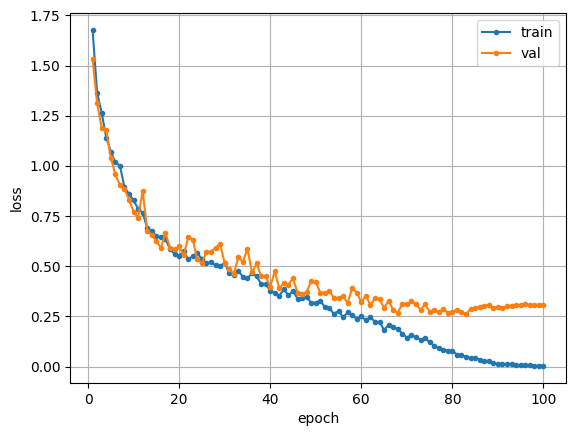

In [31]:
# グラフ描画用のFigureオブジェクトを作成
fig = plt.figure()
# Figureにサブプロット(1行1列の1つ目のプロット)を追加
ax = fig.add_subplot(111)
# x軸のデータをエポック数に基づいて作成（1からhistory['train loss']の長さまでの範囲）
xs = np.arange(1, len(history['train loss']) + 1)
# トレーニングデータの損失をプロット
ax.plot(xs, history['train loss'], '.-', label='train')
# バリデーションデータの損失をプロット
ax.plot(xs, history['val loss'], '.-', label='val')

ax.set_xlabel('epoch') # x軸のラベルを設定
ax.set_ylabel('loss') # y軸のラベルを設定
ax.legend() # 凡例を表示
ax.grid() # グリッドを表示
plt.show() # グラフを表示


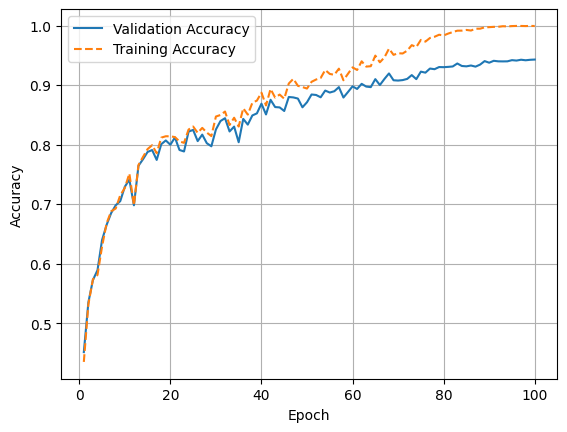

In [32]:
# グラフ描画用のFigureオブジェクトを作成
fig = plt.figure()
# Figureにサブプロット(1行1列の1つ目のプロット)を追加
ax = fig.add_subplot(111)
# x軸のデータをエポック数に基づいて作成（1からhistory['val acc']の長さまでの範囲）
xs = np.arange(1, len(history['val acc']) + 1)
# バリデーションデータの正解率をプロット
ax.plot(xs, history['val acc'], label='Validation Accuracy', linestyle='-')
# トレーニングデータの正解率をプロット
ax.plot(xs, history['train acc'], label='Training Accuracy', linestyle='--')
ax.set_xlabel('Epoch') # x軸のラベルを設定
ax.set_ylabel('Accuracy') # y軸のラベルを設定
ax.grid() # グリッドを表示
ax.legend()  # 凡例を追加
plt.show() # グラフを表示
